# CNN

In [1]:
import os
import numpy as np

In [2]:
def walk_through_directory(dirname) : 
  for pathname, dirnames, filenames in os.walk(dirname) : 
    print(f"Có {len(dirnames)} thư mục con và {len(filenames)} files trong thư mục {pathname}")

In [3]:
data_dir = "dataset"
walk_through_directory(data_dir)

Có 4 thư mục con và 0 files trong thư mục dataset
Có 0 thư mục con và 1282 files trong thư mục dataset\AI-generated
Có 0 thư mục con và 1100 files trong thư mục dataset\Digital-painting
Có 0 thư mục con và 1107 files trong thư mục dataset\Drawing
Có 0 thư mục con và 1199 files trong thư mục dataset\Photographic


Lấy danh sách các label của tập dữ liệu

In [4]:
import pathlib
pathdir = pathlib.Path(data_dir)
class_names = [item.name for item in pathdir.glob('*')]
num_classes = len(class_names)
print(f"Có {num_classes} classes: {class_names}")

Có 4 classes: ['AI-generated', 'Digital-painting', 'Drawing', 'Photographic']


In [5]:
import matplotlib.pyplot as plt
import random
import math

In [6]:
def get_random_images(target_dir, n_samples=1) : 
  target_class_names = random.sample(os.listdir(target_dir),k=n_samples)
  target_class_paths = [os.path.join(target_dir, class_name) for class_name in target_class_names]
  n_cols = 2
  n_rows = math.ceil(n_samples / n_cols)
  plt.figure(figsize=(n_cols * 4 , n_rows * 4))
  for i, class_path in enumerate(target_class_paths) :
    random_image_name = random.choice(os.listdir(class_path))
    random_image_path = os.path.join(class_path, random_image_name)
    image = plt.imread(random_image_path)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(image)
    plt.axis(False)
    plt.title(target_class_names[i])    

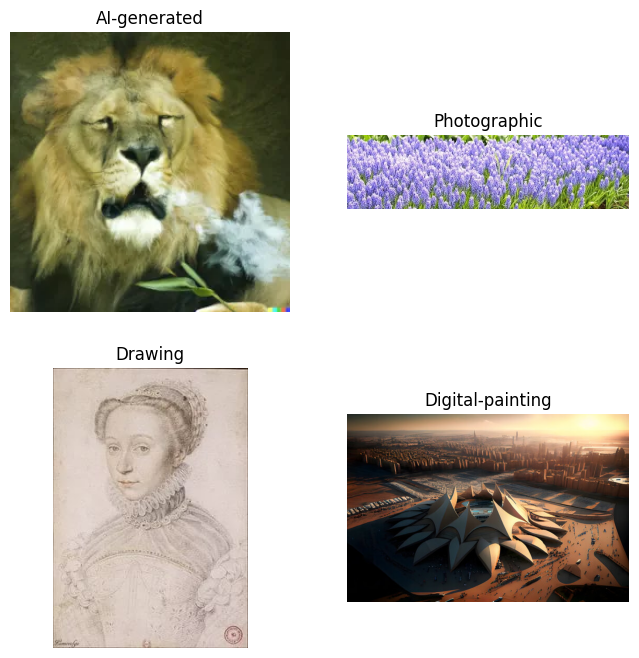

In [7]:
get_random_images(data_dir,4)

# Chuẩn bị dữ liệu
Là quá trình load dữ liệu và đồng bộ tất cả về cùng một định dạng trước khi đưa vào mô hình train. Chúng ta sẽ sử dụng ImageDataGenerator để thực hiện bước này.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)

In [10]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    subset="training"
)
test_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    subset="validation"
)

Found 3752 images belonging to 4 classes.
Found 936 images belonging to 4 classes.


# Khởi tạo mô hình

In [11]:
from tensorflow.keras import Sequential, layers

In [12]:
tf.random.set_seed(42)

model = Sequential([
                      layers.Conv2D(10,3,activation="relu", input_shape=(224,224,3)),
                      layers.Conv2D(10,3,activation="relu"),
                      layers.MaxPool2D(),
                      layers.Conv2D(10,3,activation="relu"),
                      layers.Conv2D(10,3,activation="relu"),
                      layers.MaxPool2D(),
                      layers.Flatten(),
                      layers.Dense(num_classes, activation="softmax")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

# Fit mô hình

In [14]:
# nếu file CNN_model.h5 đã tồn tại thì load lại model
if os.path.isfile("CNN_model.h5") :
    model = tf.keras.models.load_model("CNN_model.h5")
else :
    model_history = model.fit(
        train_data,
        steps_per_epoch=len(train_data), 
        epochs=5, 
        validation_data=test_data, 
        validation_steps=len(test_data)
    )
    model.save("CNN_model.h5")

Epoch 1/5
118/118 [==============================] - 265s 2s/step - loss: 1.0258 - accuracy: 0.5818 - val_loss: 1.0055 - val_accuracy: 0.5865
Epoch 2/5
118/118 [==============================] - 265s 2s/step - loss: 0.5941 - accuracy: 0.7980 - val_loss: 0.8872 - val_accuracy: 0.6656
Epoch 3/5
118/118 [==============================] - 257s 2s/step - loss: 0.3198 - accuracy: 0.8966 - val_loss: 0.6817 - val_accuracy: 0.7618
Epoch 4/5
118/118 [==============================] - 257s 2s/step - loss: 0.1485 - accuracy: 0.9531 - val_loss: 0.5745 - val_accuracy: 0.8024
Epoch 5/5
118/118 [==============================] - 263s 2s/step - loss: 0.0641 - accuracy: 0.9837 - val_loss: 0.4549 - val_accuracy: 0.8622


In [15]:
model.evaluate(test_data)

30/30 [==============================] - 22s 707ms/step - loss: 0.4549 - accuracy: 0.8622


[0.45489299297332764, 0.8621794581413269]

Vẽ đường loss_curves để đánh giá quá trình train của mô hình qua mỗi epoch

In [17]:
def plot_loss_curves(history) :
  history = history.history 
  acc,val_acc = history["accuracy"], history["val_accuracy"]
  loss,val_loss = history["loss"], history["val_loss"]

  plt.figure(figsize=(16,6))
  plt.subplot(121)
  plt.plot(acc, label="train accuracy")
  plt.plot(val_acc, label="val accuracy")
  plt.title("Accuracy")
  plt.legend()

  plt.subplot(122)
  plt.plot(loss, label="train loss")
  plt.plot(val_loss, label="val loss")
  plt.title("Loss")
  plt.legend()

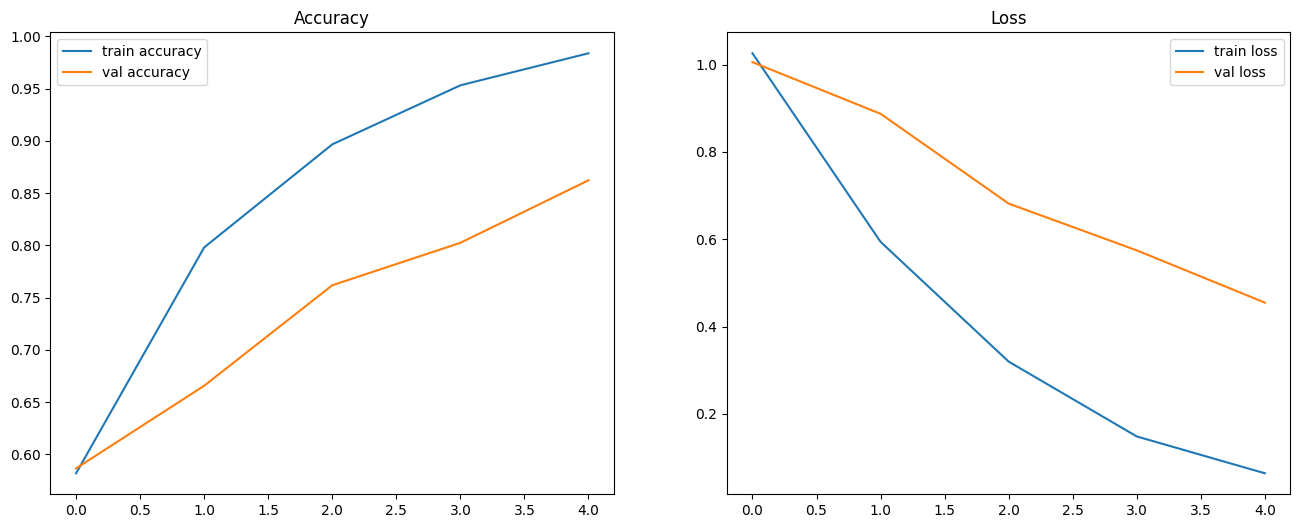

In [18]:
plot_loss_curves(model_history)

Qua biểu đồ có thể thấy:

Các đường train và test trong 2 biểu đồ gần như đi theo cùng một hướng. Chứng tỏ mô hình không bị tình trạng overfitting

# Dự đoán hình ảnh

In [19]:
os.listdir("multi_class_test")

['AI-generated.jpg', 'Digital-painting.jpg', 'Drawing.jpg', 'Photographic.jpg']

Vì đây là những hình ảnh được tải xuống chưa qua quá trình xử lý cũng như đồng bộ dữ liệu theo định dạng mà mô hình đã train trước đó nên chúng ta chưa thể đưa dữ liệu vào mô hình để train được. Trước hết, chúng ta sẽ tạo hàm để load hình và đồng bộ dữ liệu theo đúng định dạng

In [20]:
def load_and_prep_image(filepath, shape=(224,224)) : 
  # load hình ảnh 
  image = tf.io.read_file(filepath)
  # decode hình ảnh thành các giá trị dưới dạng ma trận 
  image = tf.image.decode_image(image, channels=3)
  # thay đổi kích thước hình
  image = tf.image.resize(image, size=shape)
  # trả về giá trị được chuẩn hóa
  return image/255.

In [21]:
import pandas as pd

1/1 [==============================] - 0s 189ms/step


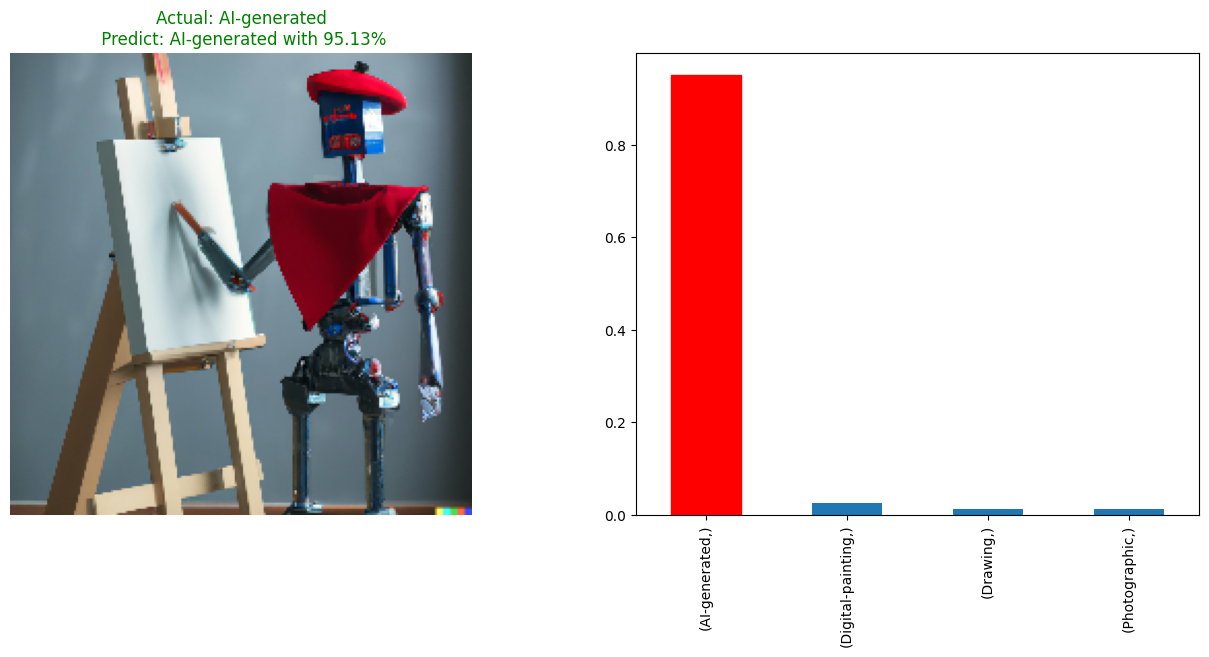

1/1 [==============================] - 0s 52ms/step


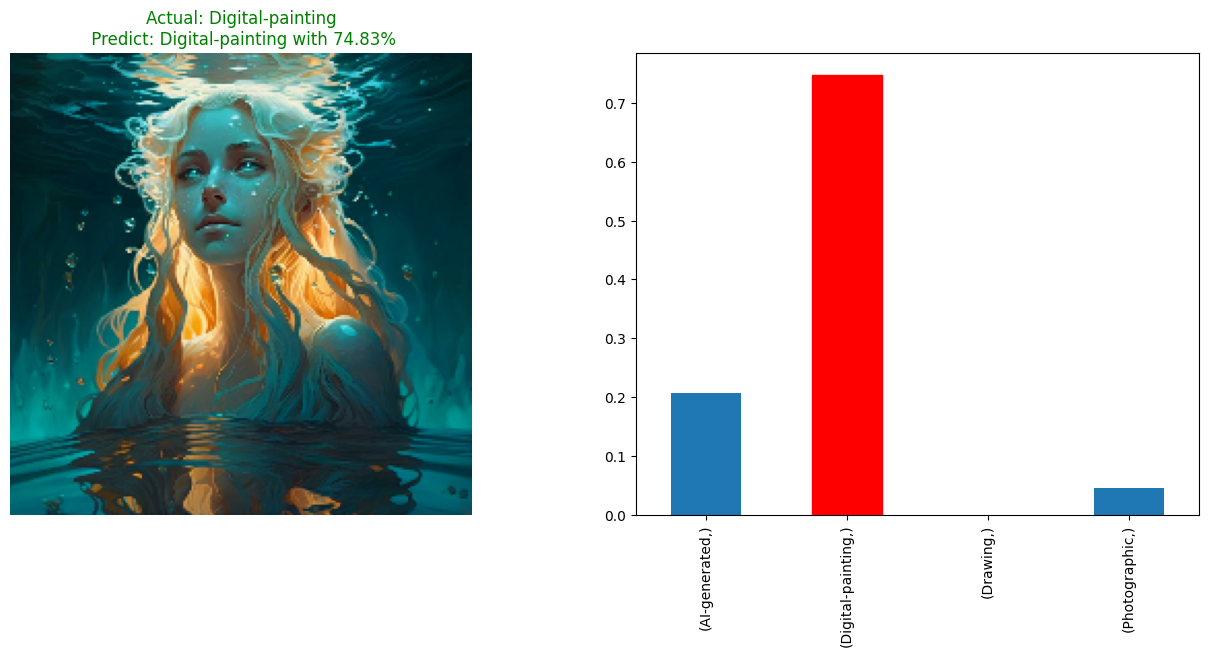

1/1 [==============================] - 0s 54ms/step


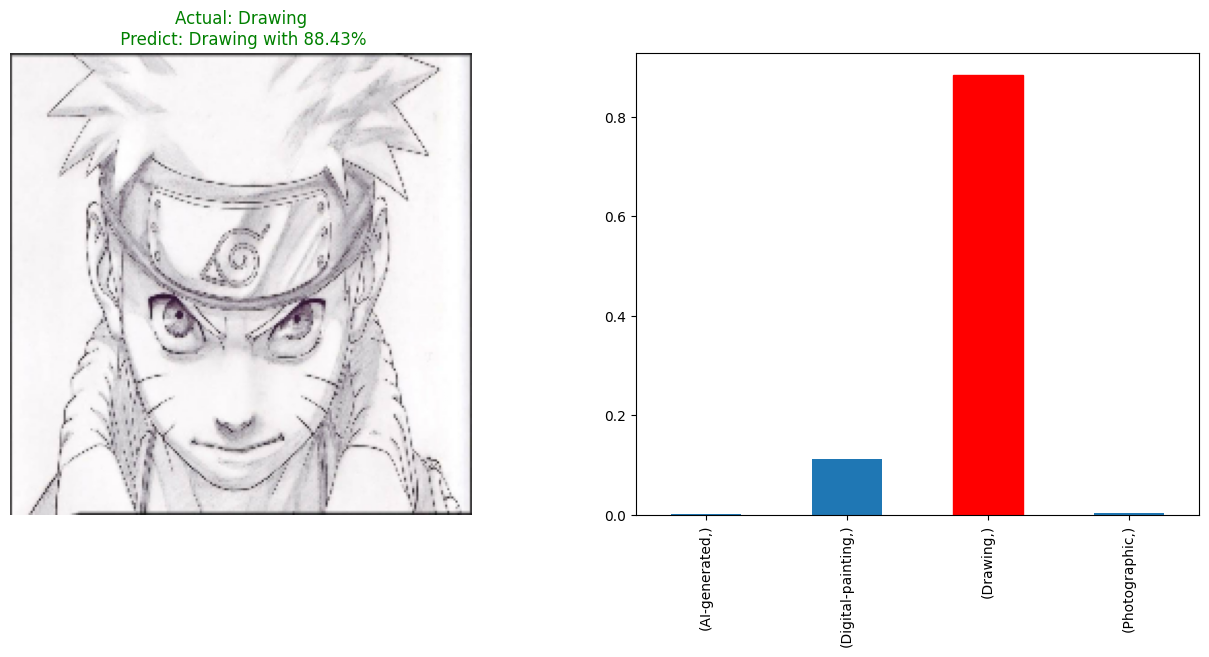

1/1 [==============================] - 0s 53ms/step


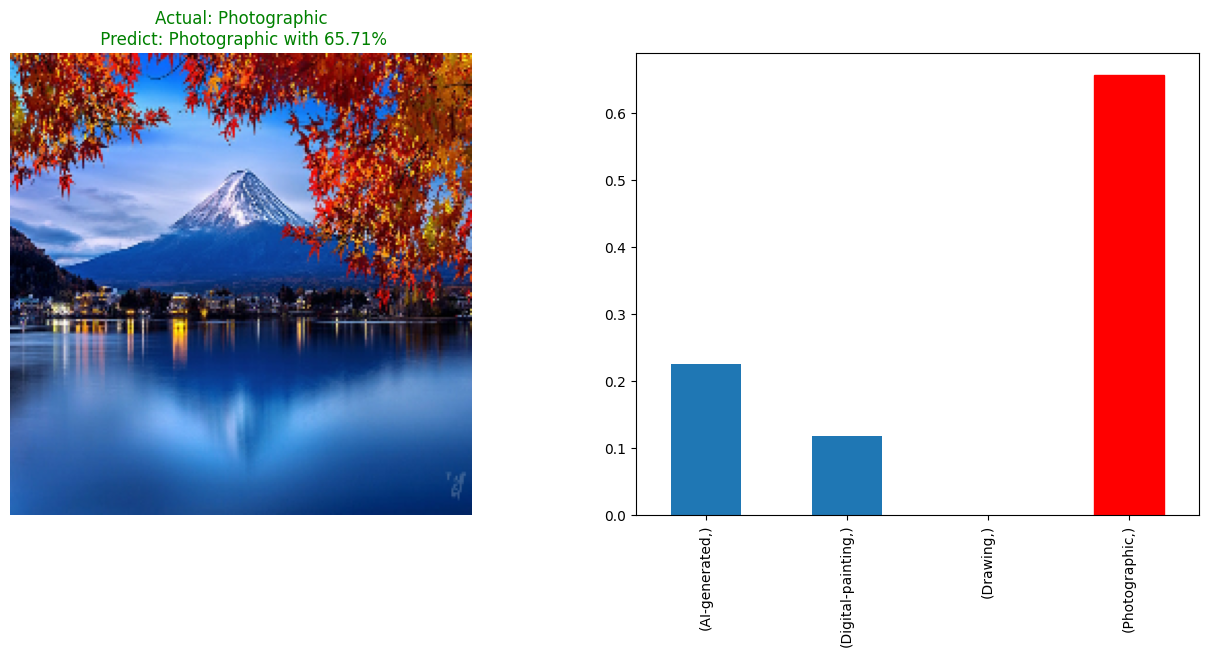

In [22]:
predicted_images_path = [os.path.join("multi_class_test", image_name) for image_name in os.listdir("multi_class_test")]

for index, image_path in enumerate(predicted_images_path) :   
  image = load_and_prep_image(image_path)
  actual_label = image_path.split("\\")[-1].split(".")[0]
  label_index = 0
  for i, class_name in enumerate(class_names) : 
    if actual_label.strip().lower() == class_name.strip().lower() : 
      label_index = i
  pred_probs = model.predict(tf.expand_dims(image, axis=0))
  max_index = tf.argmax(tf.squeeze(pred_probs))
  pred_label = class_names[max_index]
  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
  ax1.imshow(image)
  ax1.axis(False)
  if actual_label.strip().lower() ==  pred_label.strip().lower() :
    color = "green"
  else : 
    color = "red"
  ax1.set_title(f"Actual: {actual_label}\n Predict: {pred_label} with {pred_probs[0][max_index]*100:.2f}%", color=color)  
  pd.DataFrame(tf.squeeze(pred_probs), index=[class_names]).plot.bar(ax=ax2, legend=None)
  ax2.get_children()[label_index].set_color("red")
  plt.show()
     